## Wstęp do NeRF
W tym notebooku przedstawimy czym jest NeRF, do czego służy oraz jakie techniki są używane aby usprawnić jego działanie.

### Spis treści
1. [Czym jest NeRF?](#Czym-jest-NeRF?)
2. [Przetwarzanie danych przez MLP](#Przetwarzanie-danych-przez-MLP)
3. [Czym jest input dla NeRF?](#Czym-jest-input-dla-NeRF?)
4. [Renderowanie obrazu](#Renderowanie-obrazu)


#### Czym jest NeRF?

NeRF to akronim od Neural Radiance Fields for View Synthesis, co można przetłumaczyć jako Neuronowe Pola Radiacyjne do syntezy widoków.

Jest to technika wykorzystująca głębokie sieci neuronowe do generowania realistycznych renderów scen trójwymiarowych. Głównym celem NeRF jest modelowanie radiance field, czyli funkcji reprezentującej radiancję światła w trójwymiarowej przestrzeni. Prościej mówiąc, NeRF jest w stanie wygenerować fotorealistyczne obrazy scen 3D, na podstawie danych treningowych z rzeczywistych scen. 

Tradycyjne metody renderowania 3D, takie jak ray tracing czy rasterization, mają swoje ograniczenia w generowaniu szczegółowych i fotorealistycznych obrazów. NeRF stanowi innowacyjne podejście, umożliwiając renderowanie scen 3D poprzez uczenie głębokich sieci neuronowych na podstawie danych treningowych z rzeczywistych scen.

<!-- Two images in one row -->
<div style="display: flex; justify-content: center;">
    <img src="https://uploads-ssl.webflow.com/51e0d73d83d06baa7a00000f/5e700ef6067b43821ed52768_pipeline_website-01-p-800.png" alt="NeRF" width="1000" style="background-color:white;">
    <img src="https://uploads-ssl.webflow.com/51e0d73d83d06baa7a00000f/5e700a02ee168a2a63febc3b_pipeline_website-02.svg" alt="NeRF" width="500" style="background-color:white;">
    <img src="src/nerf_lego.gif">
</div>


### Przetwarzanie danych przez MLP

Reprezentujemy ciągłą scenę jako funkcję wektorową o wartościach 5D, której dane wejściowe to współrzędne w przestrzeni 3D i kierunek widzenia, a wyjściem jest kolor i gęstość objętości w danym punkcie.

Aby zbliżyć się do tej ciągłej reprezentacji sceny 5D, NeRF używa sieci neuronowej o nazwie Multi-Layer Perceptron (MLP) oznaczonej poniżej jako $F_\Theta$.

----
Opis modelu NeRF:

$$\Large F_\Theta: (x, d) → (c, σ) $$
gdzie:

$F_\Theta$ - sieć neuronowa <br/>
$x = (x, y, z)$ - współrzędne punktu w przestrzeni 3D <br/>
$c = (r, g, b)$ - kolor emitowany w danym punkcie <br/>
$d = (\theta, \phi)$ - kierunek widzenia <br/>
$\sigma$ - gęstość objętości

----


Proces ten jest realizowany poprzez przekształcenie danych wejściowych za pomocą funkcji $\gamma$ (w jaki sposób jest to realizowane jest w części o Fourier Features) i przekazanie ich do sieci neuronowej. Sieć neuronowa zawiera 8 warstw ukrytych, każda z 256 neuronami oraz aktywacją ReLU. Sieć na początku otrzymuje przetworzony wektor współrzednych (o wielkości 60), następnie w piątej warstwie dodawany jest ponownie ten wektor (żeby sieć dalej uwzględniała współrzędne punktu). W przedostatniej warstwie sieci zwracany jest gęstość objętości, a w celu uzyskania koloru emitowanego dodawany jest jeszcze przetworzony wektor kierunku widzenia (o wielkości 40). Architektura sieci neuronowej została przedstawiona poniżej.

<div style="display: flex; justify-content: center;">
<img src="src/mlp.svg" width="900" />
</div>

**Pytanie do publiczności**: Dlaczego wektory $x$ i $d$ są przetwarzane? Czy nie można było ich od razu przekazać do sieci neuronowej?

### Czym jest input dla NeRF?
Jako dataset otrzymujemy zbiór zdjęć z różnych perspektyw, ale sieć MLP potrzebuje danych w postaci $(x, d)$, gdzie wynikiem jest kolor i gęstość objętości w danym punkcie. Więc w jaki sposób możemy przekształcić zdjęcia z perspektywy na takie dane oraz jak trenować sieć neuronową? 

W celu przekształcenia zdjęć i pozycjami kamer na dane wejściowe dla sieci neuronowej, wykorzystujemy promienie (ang. rays). Promień to linia prosta łącząca kamerę z punktem na zdjęciu i przechodząca za nim. Z części promienia znajdującej się za punktem na zdjęciu, wybieramy równomiernie $n$ punktów, które są przetwarzane i przekazywane do sieci neuronowej. Otrzymujemy w ten sposób $n$ par $(x, d)$ dla każdego promienia, które są przekazywane do sieci neuronowej. Jako wyjście z MLP dostajemy $n$ kolorów i gęstości objętości, znamy również odlgełość każdego z tych punktów od kamery.
<div style="display: flex; justify-content: center;">
<img src="src/mlp_io.png" width="900" />
</div>


### Renderowanie obrazu
Aby wygenerować obraz (mając też pozycję kamery), musimy wyznaczyć kolor dla każdego piksela. W tym celu dla każdego piksela wybieramy promień, który przechodzi przez ten piksel i przekazujemy go do sieci neuronowej. Sieć zwraca kolor i gęstość objętości dla wybranych punktów na promieniu. Kolejnym krokiem jest przekazanie tych danych do funkcji $C$, która zwraca kolor dla danego promienia.

**Pytanie do publiczności**: Co robią poszczególne czynniki w poniższym wzorze na kolor?

----
Wyznanaczanie koloru dla promienia:

$$ \Large C(r) = \int_{t_{n}}^{t_{f}} T(t) \cdot \sigma(\textbf{r}(t)) \cdot \textbf{c}(\textbf{r}(t), d)  dt $$
$$ \Large T(t) = \exp \left( - \int_{t_{n}}^{t} \sigma(\textbf{r}(s)) ds \right) $$
$$ \Large \textbf{r}(t) = o + t \cdot d $$


$t_n$ - dolny zakres długości promienia <br>
$t_f$ - górny zakres długości promienia <br>
$r(t)$ - koniec wektora zaczepionego w punkcie o (czyli pozycja obserwatora) o zasiegu wektora t oraz kierunku wektora danym przez d

----

(można o tym wyżej wzorze myśleć jak o wartości oczekiwanej koloru biorąc pod uwage zakres długości promienia, koloru powierzchni przez które przechodzi promień oraz gestości obiektu przez który promień przechodzi)

<br>
<div style="display: flex; justify-content: center;">
<img src="src/promienie_gestosc.png" width="600" />
</div>

Rysunek poglądowy może pomóc zrozumieć jak gęstośc otoczenia i odległość promienia może wpływać na kolor oraz jak ten kolor potem używać do obliczania loss'u (g.t. - ground truth ;) 

Poniżej stworzyliśmy prostą implementację funkcji $C$ wzorując się [nerf_eval/utils_nerf.py](nerf_eval/utils_nerf.py) od linii 36.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def raw2outputs_single_ray(raw, z_vals, ray_d):
    def sigmoid(a):
        return 1 / (1 + np.exp(-a))

    def raw2alpha(raw, dists):
        raw = np.maximum(raw, 0)
        return 1.0 - np.exp(-raw * dists)

    # Compute 'distance' between each integration time along the ray.
    dists = np.diff(z_vals)
    dists = np.append(dists, 1e10)  # append infinity for the last distance

    # Multiply each distance by the norm of the ray direction to convert to real world distance.
    dists *= np.linalg.norm(ray_d)

    # Extract RGB of each sample position along the ray.
    rgb = sigmoid(raw[..., :3])  # [N_samples, 3]

    # Predict density of each sample along the ray.
    alpha = raw2alpha(raw[..., 3], dists)  # [N_samples]

    # Compute weight for RGB of each sample along the ray.
    weights = alpha * np.cumprod(1. - alpha + 1e-10)  # [N_samples]

    # Compute weighted color of each sample along the ray.
    rgb_map = np.sum(weights[..., None] * rgb, axis=0)  # [3]

    # Estimated depth map is expected distance.
    depth_map = np.sum(weights * z_vals)

    # Disparity map is inverse depth.
    disp_map = 1. / np.maximum(1e-10, depth_map / np.sum(weights))

    # Sum of weights along the ray.
    acc_map = np.sum(weights)

    return rgb_map, disp_map, acc_map, weights, depth_map

def plot_sample_points(z_vals, raw, weights, rgb_map):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    # Plot the densities and colors of the sample points.
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.bar(z_vals, raw[..., 3], width=0.1, color=raw[..., :3])
    plt.xlabel('Distance from camera')
    plt.ylabel('Density')
    plt.title('Density and color of sample points along the ray')

    # Normalize rgb_map to be within [0, 1].
    rgb_map = (rgb_map - np.min(rgb_map)) / (np.max(rgb_map) - np.min(rgb_map))

    # Create a custom legend with the predicted color.
    legend_elements = [Patch(facecolor=rgb_map, edgecolor='r', label='Predicted color')]
    plt.legend(handles=legend_elements, loc='upper right')

    # Plot the weights of the sample points.
    plt.subplot(2, 1, 2)
    plt.bar(z_vals, weights, width=0.1)
    plt.xlabel('Distance from camera')
    plt.ylabel('Weight')
    plt.title('Weights of sample points along the ray')

    plt.tight_layout()
    plt.show()

    # Print the rendered color of the ray.
    print('Rendered color of the ray:', rgb_map)

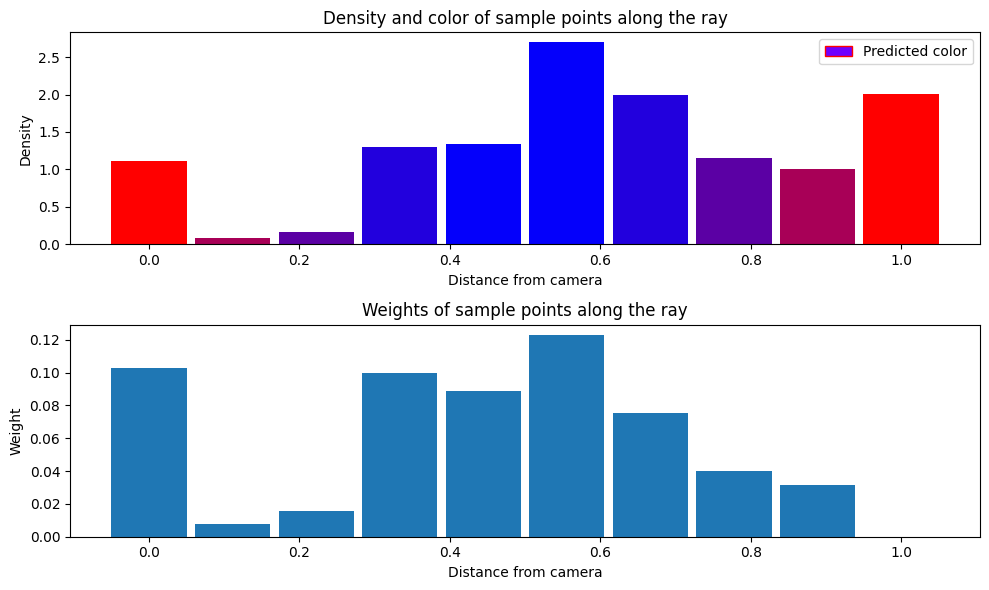

Rendered color of the ray: [0.4333938 0.        1.       ]


In [28]:
# Create a single ray with 10 sample points.
N_samples = 10
z_vals = np.linspace(0, 1, N_samples)  # Sample positions along the ray.
ray_d = np.array([0, 0, 1])  # Ray direction.

# Create random colors and densities for each sample point.
raw = np.random.rand(N_samples, 4)
raw[..., :3] = raw[..., :3]  # Keep colors within [0, 1].
raw[..., 3] = raw[..., 3] * 3  # Convert densities to [0, 3].

# Define the two colors.
color1 = np.array([1, 0, 0])  # Red.
color2 = np.array([0, 0, 1])  # Blue.

# Normalize z_vals to be within [0, 1].
z_vals_normalized = (z_vals - np.min(z_vals)) / (np.max(z_vals) - np.min(z_vals))

# Create a sinusoidal gradient color mapping based on distance.
raw[..., :3] = color1[None, :] + (color2 - color1)[None, :] * np.sin(np.pi * z_vals_normalized)[:, None]

# Render the color of the ray.
rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs_single_ray(raw, z_vals, ray_d)

# Plot the sample points.
plot_sample_points(z_vals, raw, weights, rgb_map)

### Proces trenowania

Trenowanie tej sieci można przedstawić w następujących krokach:

1. Odpowienie przygotowanie danych. Bedziemy potrzebować wykonanych zdjęć wraz z pozcją kamery.
2. W każdej iteracji jest losowany zestaw promieni dla których bedzie liczony kolor
3. Dla każdego wylosowanego promienia jest obliczanych N wylosowanych próbek na całej jego długości
4. Z wylosowanych próbek za pomocą renderowania objętości jest obliczany kolor
5. Ostatnim krokiem jest obliczanie loss'u



----
Loss:

$$ \Large L =  \sum_{r \in R} \Vert \hat{C}(r) - C(r) \Vert^2_2 $$

gdzie:

$R$ - zbiór promieni <br/>
$\hat{C}(r)$ - kolor wygenerowany przez sieć neuronową <br/>
$C(r)$ - kolor oczekiwany <br/>

----

## Usprawnienie modelu

#### Jedną z najwazniszych rzeczy jakie można zrobić to Fourier Feature

Operowanie na suchych współrzednych x,y,z przynosi słabe rezultaty w kontekście szczegółów i kolorów na obrazku, autorzy pracy powołując sie na innych badaczy dokonują następującej transformacji:

$$ \Large \gamma(p) = \left[ \cos(2^0 \pi p), \sin(2^0 \pi p), \cos(2^1 \pi p), \sin(2^1 \pi p), \dots, \cos(2^{L-1} \pi p), \sin(2^{L-1} \pi p) \right] $$

gdzie:

$p = x * B$ <br>
$B$ - macierz gausowska z rozkładu $N(\mu, \sigma^2)$

Poniższy przykład pokazuje jak może wygląda nauka z użyciem Fourier Feature i bez niego, gołym okiem widać na obrazku oraz na lossie różnice

<div style="padding: 10px;">
<img src="src/lion_none_gauss_v1.gif" width="2000" />
</div>

Należy jednak uważać, ponieważ nieodpowiednie dobranie parametrów może doprowadzić do pogorszenia jakości zdjeć, tyczy sie to parametru L

<div style="padding: 10px;">
<img src="src/test_sweep_1e-4_5000_more_low.gif" width="2000" />
</div>

## Rezultaty

<div style="padding: 10px;">
<img src="src/res3.png" width="2000" />
</div>

<div style="padding: 10px;">
<img src="src/res2.png" width="2000" />
</div>

<div style="padding: 10px;">
<img src="src/res1.png" width="2000" />
</div>
